In [1]:
import os
import pandas as pd

from pprint import pprint

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ExponentialLR

#from pytorch_lightning import LightningModule, Trainer, seed_everything

from transformers import BertForSequenceClassification, BertTokenizer, AdamW

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import re
from soynlp.normalizer import repeat_normalize

In [2]:
device = torch.device("cuda:0")

In [3]:
unsmile_labels = ["여성/가족","남성","성소수자","인종/국적","연령","지역","종교","기타 혐오","악플/욕설","clean"]

In [4]:
#model load
from transformers import AutoTokenizer, BertForSequenceClassification
MODEL_NAME= 'monologg/kobert'
tokenizer = AutoTokenizer.from_pretrained('monologg/kobert')
#model = BertForSequenceClassification.from_pretrained(MODEL_NAME)

# Load Dataset

In [5]:
import pandas as pd
data_path ='C:/Users/USER/Desktop/2021_korean_hate_speech_detection/hs_CORAL/dataset/'
unsmile_train_dataset = pd.read_csv(data_path+"Unsmile_train_dataset.csv")
#unsmile_train_dataset = pd.concat([unsmile_train_dataset['문장'], unsmile_train_dataset['labels']], axis=1)
unsmile_test_dataset = pd.read_csv(data_path+"Unsmile_test_dataset.csv")
#unsmile_test_dataset = pd.concat([unsmile_test_dataset['문장'], unsmile_test_dataset['labels']], axis=1)
unsmile_train_dataset.head(5)

,문장,여성/가족,남성,성소수자,인종/국적,연령,지역,종교,기타 혐오,악플/욕설,clean,개인지칭,labels
0,일안하는 시간은 쉬고싶어서 그런게 아닐까,0,0,0,0,0,0,0,0,0,1,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
1,아동성범죄와 페도버는 기록바 끊어져 영원히 고통 받는다. 무슬림 50퍼 근친이다. ...,0,0,0,0,0,0,1,0,0,0,0,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
2,루나 솔로앨범 나왔을 때부터 머모 기운 있었음 ㅇㅇ Keep o doin 진짜 띵...,0,0,0,0,0,0,0,0,0,1,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
3,홍팍에도 어버이연합인가 보내요 뭐 이런뎃글 있는데 이거 어버이연합측에 신고하면 그쪽...,0,0,0,0,0,0,0,0,0,1,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
4,아놔 왜 여기 댓들은 다 여자들이 김치녀라고 먼저 불렸다! 여자들은 더 심하게 그런...,1,0,0,0,0,0,0,0,0,0,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [6]:
tokenized_train_sentences = tokenizer(
                            list(unsmile_train_dataset['문장']),
                            return_tensors="pt",
                            max_length=64,
                            padding=True,
                            truncation=True,
                            add_special_tokens=True)

tokenized_test_sentences = tokenizer(
                            list(unsmile_test_dataset['문장']),
                            return_tensors="pt",
                            max_length=64,
                            padding=True,
                            truncation=True,
                            add_special_tokens=True)

In [7]:
tokenized_train_sentences

{'input_ids': tensor([[2, 0, 0,  ..., 1, 1, 1],
        [2, 0, 0,  ..., 1, 1, 1],
        [2, 0, 0,  ..., 1, 1, 1],
        ...,
        [2, 0, 0,  ..., 1, 1, 1],
        [2, 0, 0,  ..., 1, 1, 1],
        [2, 0, 0,  ..., 1, 1, 1]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [8]:
def labels_to_tensor(label_df):

    label_list = list()
    for k in range(len(label_df['labels'])):
        item = label_df['labels'][k]
        tmp_label = list()
        for i in range(1, 30, 3):
            label = int(item[i])
            tmp_label.append(label)
        label_list.append(tmp_label)
    return torch.tensor(label_list, dtype=torch.float64)

In [9]:
tokenized_train_sentences['labels'] = labels_to_tensor(unsmile_train_dataset)
tokenized_train_sentences
tokenized_test_sentences['labels'] = labels_to_tensor(unsmile_test_dataset)
tokenized_test_sentences

{'input_ids': tensor([[   2,    0, 7347,  ...,    1,    1,    1],
        [   2,    0,    0,  ...,    1,    1,    1],
        [   2,    0, 5782,  ...,    1,    1,    1],
        ...,
        [   2,    0,    0,  ...,    1,    1,    1],
        [   2,  497,    0,  ...,    1,    1,    1],
        [   2,    0,    0,  ...,    1,    1,    1]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
  

In [74]:
from transformers import BertForSequenceClassification
num_labels=len(unsmile_labels) # Label 갯수

model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME, 
    num_labels=num_labels, 
    problem_type="multi_label_classification"
)
model.config.id2label = {i: label for i, label in zip(range(num_labels), unsmile_labels)}
model.config.label2id = {label: i for i, label in zip(range(num_labels), unsmile_labels)}

loading configuration file https://huggingface.co/monologg/kobert/resolve/main/config.json from cache at C:\Users\USER/.cache\huggingface\transformers\31dc8da633439f22ed80bede01f337996bc709eb8429f86f2b24e2103558b039.89a06cdfd16840fd89cc5c2493ef63cd0b6068e85f70ac988a3673e2722cab2e
Model config BertConfig {
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8,
    "LABEL_9": 9
  },
  "layer_norm_eps": 1e-12,
 

In [48]:
model.config.label2id

{'여성/가족': 0,
 '남성': 1,
 '성소수자': 2,
 '인종/국적': 3,
 '연령': 4,
 '지역': 5,
 '종교': 6,
 '기타 혐오': 7,
 '악플/욕설': 8,
 'clean': 9}

In [49]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item
    
    def __len__(self):
        return len(self.encodings)

In [50]:
train_dataset = MyDataset(tokenized_train_sentences)
test_dataset = MyDataset(tokenized_test_sentences)

In [51]:
train_dataset[1]['labels'].dtype

C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


torch.float64

# Model training

In [52]:
from sklearn.metrics import label_ranking_average_precision_score

In [53]:
def compute_metrics(x):
    return {
        'lrap': label_ranking_average_precision_score(x.label_ids, x.predictions),
    }

In [54]:
batch_size = 64 

In [58]:
from transformers import TrainingArguments
from transformers import Trainer

args = TrainingArguments(
    output_dir="KoBERT_unsmile",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=10,
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='lrap',
    greater_is_better=True,
)

trainer = Trainer(
    model=model, 
    args=args, 
    train_dataset=train_dataset, 
    eval_dataset=test_dataset, 
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [59]:
trainer.train()

***** Running training *****
  Num examples = 4
  Num Epochs = 10
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 10
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Epoch,Training Loss,Validation Loss,Lrap
1,No log,0.673381,0.275694
2,No log,0.662984,0.267361
3,No log,0.653778,0.267361
4,No log,0.644532,0.204861
5,No log,0.636750,0.167659
6,No log,0.630771,0.165179
7,No log,0.626409,0.165179
8,No log,0.622649,0.169643
9,No log,0.620232,0.169643
10,No log,0.618542,0.169643


***** Running Evaluation *****
  Num examples = 4
  Batch size = 64
Saving model checkpoint to KoBERT_unsmile\checkpoint-1
Configuration saved in KoBERT_unsmile\checkpoint-1\config.json
Model weights saved in KoBERT_unsmile\checkpoint-1\pytorch_model.bin
tokenizer config file saved in KoBERT_unsmile\checkpoint-1\tokenizer_config.json
Special tokens file saved in KoBERT_unsmile\checkpoint-1\special_tokens_map.json
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
***** Running Evaluation *****
  Num examples = 4
  Batch size = 64
Saving model checkpoint to KoBERT_unsmile\checkpoint-2
Configuration saved in KoBERT_unsmile\checkpoint-2\config.json
Model weights saved in KoBERT_unsmile\checkpoint-2\pytorch_model.bin
tokenizer config file saved in KoBERT_un

TrainOutput(global_step=10, training_loss=0.620839786529541, metrics={'train_runtime': 19.1771, 'train_samples_per_second': 2.086, 'train_steps_per_second': 0.521, 'total_flos': 1315649771520.0, 'train_loss': 0.620839786529541, 'epoch': 10.0})

In [60]:
trainer.save_model()

Saving model checkpoint to KoBERT_unsmile
Configuration saved in KoBERT_unsmile\config.json
Model weights saved in KoBERT_unsmile\pytorch_model.bin
tokenizer config file saved in KoBERT_unsmile\tokenizer_config.json
Special tokens file saved in KoBERT_unsmile\special_tokens_map.json


In [63]:
from transformers import TextClassificationPipeline

pipe = TextClassificationPipeline(
    model = model,
    tokenizer = tokenizer,
    device=0,
    return_all_scores=True
    #function_to_apply='sigmoid'
    )

In [64]:
results_list = list()
for result in pipe("이래서 여자는 게임을 하면 안된다")[0]:
    results_list.append(result['score'])
    print(result)

{'label': '여성/가족', 'score': 0.60089111328125}
{'label': '남성', 'score': 0.6203008890151978}
{'label': '성소수자', 'score': 0.6309871077537537}
{'label': '인종/국적', 'score': 0.6115855574607849}
{'label': '연령', 'score': 0.6357312798500061}
{'label': '지역', 'score': 0.6196723580360413}
{'label': '종교', 'score': 0.628574550151825}
{'label': '기타 혐오', 'score': 0.5906829237937927}
{'label': '악플/욕설', 'score': 0.6201616525650024}
{'label': 'clean', 'score': 0.6277750730514526}


In [65]:
results_list

[0.60089111328125,
 0.6203008890151978,
 0.6309871077537537,
 0.6115855574607849,
 0.6357312798500061,
 0.6196723580360413,
 0.628574550151825,
 0.5906829237937927,
 0.6201616525650024,
 0.6277750730514526]

In [66]:
import transformers
transformers.__version__

'4.15.0'

# Evaluation

In [67]:
trainer.evaluate(eval_dataset=test_dataset)

***** Running Evaluation *****
  Num examples = 4
  Batch size = 64
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


{'eval_loss': 0.6733812689781189,
 'eval_lrap': 0.27569444444444446,
 'eval_runtime': 0.1356,
 'eval_samples_per_second': 29.49,
 'eval_steps_per_second': 7.373,
 'epoch': 10.0}

In [68]:
def get_predicated_label(output_labels, min_score):
    labels = []
    for label in output_labels:
        if label['score'] > min_score:
            labels.append(1)
        else:
            labels.append(0)
    return labels

In [69]:
unsmile_test_dataset['문장']

0       ㅇㄱㄹㅇ 진짜 죽어도 상관없다는 마인드로 싸웠더니 지금 서열 상타취노 식칼들고 니가...
1                              여자들은 취미가 애낳는건가.. 취미를 좀 가져라
2                                개슬람녀 다 필요없고 니 엄마만 있으면 된다
3       조팔ㅋㅋ 남한 길거리 돌아다니면 한국남자때문에 눈재기하는데 그걸 내 폰에 굳이 담아...
4                                   바지 내리다 한남들 와꾸 보고 올려뿟노
                              ...                        
3732                          저게 시대적언어면 한남충도 시대적언어 아니노 ㅋㅋ
3733                             다른것보다 눈이 어떻게 저렇게 생기노.탄식.
3734               막노동을 해도 한국에살고말지 미쳤다고 남미를가냐?차라리 자살을하겠다.
3735    ‘사형을 구형하였으나 여성인 점을 감안해 25년 선고’ ???내가 뭐 잘못본건가?개...
3736                              참군남이노 남자의 용도는 고기방패다 ㅋㅋㅋ
Name: 문장, Length: 3737, dtype: object

In [70]:
from transformers.pipelines.base import KeyDataset

predicated_labels = []

for sentence in unsmile_test_dataset['문장']:
    for out in pipe(sentence):
        predicated_labels.append(get_predicated_label(out, 0.5))

C:\Users\USER\AppData\Roaming\Python\Python36\site-packages\transformers\pipelines\base.py:1077: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


In [71]:
predicated_labels

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1,

In [72]:
from sklearn.metrics import classification_report
unsmile_test = pd.read_csv(data_path+"Unsmile_test_dataset.csv")
print(classification_report(labels_to_tensor(unsmile_test), predicated_labels))

              precision    recall  f1-score   support

           0       0.11      1.00      0.19       394
           1       0.09      1.00      0.16       334
           2       0.07      1.00      0.14       280
           3       0.11      1.00      0.20       426
           4       0.04      1.00      0.08       146
           5       0.07      1.00      0.13       260
           6       0.08      1.00      0.14       290
           7       0.04      1.00      0.07       134
           8       0.21      1.00      0.35       786
           9       0.25      1.00      0.40       935

   micro avg       0.11      1.00      0.19      3985
   macro avg       0.11      1.00      0.19      3985
weighted avg       0.15      1.00      0.25      3985
 samples avg       0.11      1.00      0.19      3985



In [43]:
from sklearn.metrics import classification_report, confusion_matrix
cf_matrix = confusion_matrix(labels_to_tensor(unsmile_test), predicated_labels)

ValueError: multilabel-indicator is not supported

In [40]:
unsmile_test['labels'][0]

'[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]'

In [36]:
unsmile_train_dataset["labels"][1]

'[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]'

In [24]:
train_dataset.__getitem__(1)

C:\Users\USER\anaconda3\envs\badText10\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


TypeError: new(): invalid data type 'str'

In [15]:
koco_train_dataloader = torch.utils.data.DataLoader(koco_train_BERTDataset, batch_size=batch_size, num_workers=0)
koco_test_dataloader = torch.utils.data.DataLoader(koco_test_BERTDataset, batch_size=batch_size, num_workers=0)

# Model

In [16]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=3,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [17]:
model = BERTClassifier(num_classes,  dr_rate=0.5).to(device)

In [18]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [19]:
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.BCWithLogitsLoss()

In [20]:
t_total = len(koco_train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

In [21]:
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [22]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

# Train Model

In [23]:
import time
start_time = time.time()

# to track the training loss as the model trains
train_losses = []
# to track the validation loss as the model trains
valid_losses = []
# to track the average training loss per epoch as the model trains
avg_train_losses = []
# to track the average validation loss per epoch as the model trains
avg_valid_losses = [] 
    
early_stopping = EarlyStopping(patience=patience, verbose=True, path=path)

for e in range(num_epochs):
    model.train()
    train_epoch_pred=[]
    train_loss_record=[]
    
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(koco_train_dataloader)):
        optimizer.zero_grad()
        
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        
        label = label.long().to(device)
        
        out = model(token_ids, valid_length, segment_ids)
        
        loss = loss_fn(out, label) #BCWithLogitloss loss
        train_loss_record.append(loss)
        train_pred=out.detach().cpu().numpy()
        train_real=label.detach().cpu().numpy()
        
        train_epoch_pred.append(train_pred)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_losses.append(loss.item())
        
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
        
        del loss, label, token_ids, valid_length, segment_ids, out
        torch.cuda.empty_cache()
        
    train_epoch_pred = np.concatenate(train_epoch_pred)
    train_epoch_target=train_dataloader.dataset.labels
    train_epoch_result=calculate_metrics(target=train_epoch_target, pred=train_epoch_pred)
       
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
end_time = time.time()
print("train_run_time: ", float(end_time) - float(start_time))

  0%|          | 0/124 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 1.0209240913391113 train acc 0.5
epoch 1 train acc 0.6294942876344086


  0%|          | 0/124 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.8348466157913208 train acc 0.625
epoch 2 train acc 0.7232862903225806


  0%|          | 0/124 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.6860823035240173 train acc 0.71875
epoch 3 train acc 0.790112567204301


  0%|          | 0/124 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.5598117113113403 train acc 0.8125
epoch 4 train acc 0.8501344086021506


  0%|          | 0/124 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.5614600777626038 train acc 0.78125
epoch 5 train acc 0.8866347446236559


  0%|          | 0/124 [00:00<?, ?it/s]

epoch 6 batch id 1 loss 0.2864173948764801 train acc 0.890625
epoch 6 train acc 0.9367439516129032


  0%|          | 0/124 [00:00<?, ?it/s]

epoch 7 batch id 1 loss 0.2612796425819397 train acc 0.921875
epoch 7 train acc 0.9536290322580645


  0%|          | 0/124 [00:00<?, ?it/s]

epoch 8 batch id 1 loss 0.23065674304962158 train acc 0.921875
epoch 8 train acc 0.9712701612903226


  0%|          | 0/124 [00:00<?, ?it/s]

epoch 9 batch id 1 loss 0.13765768706798553 train acc 0.953125
epoch 9 train acc 0.9812247983870968


  0%|          | 0/124 [00:00<?, ?it/s]

epoch 10 batch id 1 loss 0.11843327432870865 train acc 0.96875
epoch 10 train acc 0.9860131048387096
train_run_time:  271.9274363517761


In [24]:
torch.save(model.state_dict(), 'koco_bias_kobert_model.pt')

# Test Model

In [25]:
preds_torch_list=[] #predict 값 list 생성
test_acc=0
#model_path = 'C:/Users/USER/Desktop/2022/koco_kobert_model.pt'
#model_path = 'koco_kobert_model.pt'
#model.load_state_dict(torch.load(model_path))
model.eval()
for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(koco_test_dataloader)):
    with torch.no_grad():
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        preds_torch_list.append(out)
        
        del label, token_ids, valid_length, segment_ids, out
        torch.cuda.empty_cache()

  0%|          | 0/8 [00:00<?, ?it/s]

In [26]:
preds_list = list()
for temp_list in preds_torch_list:
    max_vals, max_indices = torch.max(torch.tensor(temp_list), axis=1)
    max_list = max_indices.tolist()
    preds_list.extend(max_list)

C:\Users\USER\anaconda3\envs\badText10\lib\site-packages\ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


# Confusion Matrix

In [27]:
y_test = koco_test_BERTDataset.labels
preds_list = preds_list

              precision    recall  f1-score   support

           0       0.89      0.84      0.86       342
           1       0.42      0.53      0.47        62
           2       0.69      0.70      0.70        67

    accuracy                           0.78       471
   macro avg       0.66      0.69      0.68       471
weighted avg       0.80      0.78      0.79       471



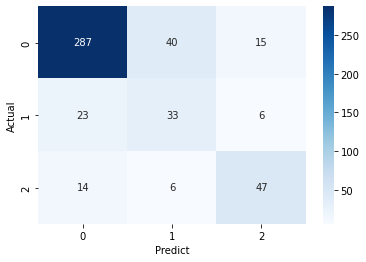

In [28]:
## classification_report
from sklearn.metrics import classification_report
clf_report = classification_report(y_test, preds_list)
print(clf_report)

# 오차행렬 생성
from sklearn.metrics import classification_report, confusion_matrix
cf_matrix = confusion_matrix(y_test, preds_list)

# 오차행렬 시각화
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()

In [29]:
from coral_pytorch.dataset import proba_to_label

def compute_mae_and_mse(label, preds_list):

    mae, mse = 0., 0.
    num_examples = len(label)
    targets = torch.tensor(label)
    predicted_labels = torch.tensor(preds_list)
    
    mae += torch.sum(torch.abs(predicted_labels - targets))
    mse += torch.sum((predicted_labels - targets)**2)

    mae = mae / num_examples
    mse = mse / num_examples
    return mae, mse

In [30]:
mae, mse = compute_mae_and_mse(y_test, preds_list)
print(mae)
print(mse)

tensor(0.2824)
tensor(0.4055)
